In [167]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [39]:
name_map = pd.read_csv("../../data/misc/HUMAN_9606_idmapping.gene_prot.dat",
                       sep='\t',
                       names=['ID', 'type', 'code'])
name_map = name_map.drop_duplicates(['ID', 'type'])
name_map = pd.pivot(name_map, index='ID', columns='type', values='code').dropna()

name_map_dict = dict(zip(name_map['UniProtKB-ID'].values, name_map['Gene_Name'].values))

# load data

In [80]:
procan_protein = pd.read_csv("../../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control.txt", sep='\t')

procan_protein = procan_protein.set_index('Cell_line')

cols = [x for x in procan_protein.columns if x in name_map_dict]

procan_protein = procan_protein[cols]

gene_cols = procan_protein.columns.map(name_map_dict)

procan_protein.columns = gene_cols

procan_protein = procan_protein.loc[:,~procan_protein.columns.duplicated()]


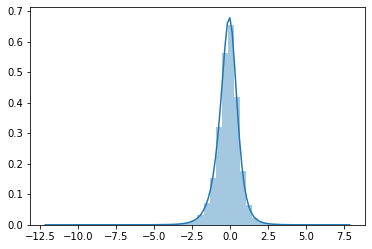

In [81]:
sns.distplot(procan_protein.values.flatten())

In [ ]:
brca = pd.read_csv("../../data/cptac/TCGA_Breast_BI_Proteome.itraq.tsv", sep='\t')

cols = ['Gene'] + [x for x in brca.columns if 'Log Ratio'in x and 'Unshared' not in x]

brca_df = brca[cols].iloc[3:,:].set_index('Gene').T
brca_df.index.name = 'Sample'

In [82]:
ov = pd.read_csv("../../data/cptac/TCGA_Ovarian_JHU_Proteome.itraq.tsv", sep='\t')

cols = ['Gene'] + [x for x in ov.columns if 'Log Ratio'in x and 'Unshared' not in x]

ov_df = ov[cols].iloc[3:,:].set_index('Gene').T
ov_df.index.name = 'Sample'

In [84]:
overlap_genes = sorted(set(procan_protein.columns).intersection(brca_df.columns).intersection(ov_df.columns))

In [86]:
procan_df_common = procan_protein[overlap_genes]
brca_df_common = brca_df[overlap_genes]
ov_df_common = ov_df[overlap_genes]

 # train tissue classifier

In [149]:
meta = pd.read_csv("../../data/E0022_P06_final_sample_map_no_control.txt",sep='\t')

In [150]:
tissue_type_map = meta[[
    'Cell_line', 'Cancer_type', 'Tissue_type'
]].drop_duplicates().set_index('Cell_line').to_dict()['Tissue_type']

In [151]:
procan_df_common['Tissue'] = procan_df_common.index.map(tissue_type_map)

<ipython-input-151-be766f3c64a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  procan_df_common['Tissue'] = procan_df_common.index.map(tissue_type_map)


In [152]:
procan_df_common['Tissue'] = procan_df_common['Tissue'].map(lambda x:'Other' if x not in ['Breast', 'Ovary'] else x)

<ipython-input-152-a0bd5a80d47f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  procan_df_common['Tissue'] = procan_df_common['Tissue'].map(lambda x:'Other' if x not in ['Breast', 'Ovary'] else x)


In [153]:
procan_df_common_no_other = procan_df_common[procan_df_common['Tissue']!='Other']

In [154]:
seed = 42
data = procan_df_common
X = data.drop(['Tissue'], axis=1)
y = data['Tissue']
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-2.242616)
if imputer:
    X = imputer.fit_transform(X)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed, shuffle=True,
                                                    test_size=0.2)

In [155]:
params = {'max_bin': 500, 'n_estimators': 700, 'num_leaves': 21, 'n_jobs': -1}
clf = LGBMClassifier(**params)

In [168]:
params = {'max_features': "sqrt", 'n_estimators': 1000, 'n_jobs':-1}
clf = RandomForestClassifier(**params)

In [169]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [170]:
y_pred = clf.predict(X_test)

Text(0.5, 1.0, 'Normalised confusion matrix for tissue type prediction')

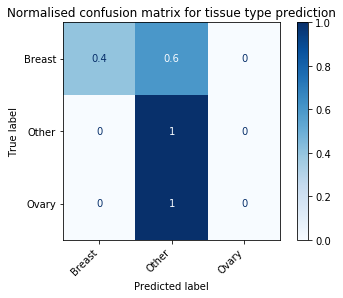

In [171]:
plot_confusion_matrix(clf,
                      X_test,
                      y_test,
                      cmap=plt.cm.Blues,
                      normalize='true')
plt.xticks(rotation=45, ha='right')
plt.title("Normalised confusion matrix for tissue type prediction")

# predict cptac

In [159]:
X_cptac = pd.concat([brca_df_common, ov_df_common])
y_cptac = ['Breast'] * brca_df_common.shape[0] + ['Ovary']*ov_df_common.shape[0]

In [160]:
X_cptac = scaler.transform(X_cptac)

In [161]:
y_pred = clf.predict(X_cptac)

In [162]:
print(classification_report(y_cptac, y_pred))

              precision    recall  f1-score   support

      Breast       1.00      0.02      0.04       111
       Other       0.00      0.00      0.00         0
       Ovary       0.00      0.00      0.00       132

    accuracy                           0.01       243
   macro avg       0.33      0.01      0.01       243
weighted avg       0.46      0.01      0.02       243



/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Normalised confusion matrix for tissue type prediction')

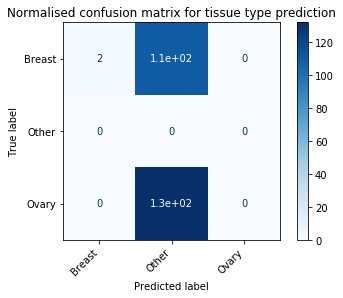

In [147]:
plot_confusion_matrix(clf,
                      X_cptac,
                      y_cptac,
                      cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title("Normalised confusion matrix for tissue type prediction")